In [1]:
pip install opencv-python==3.4.2.16 opencv-contrib-python==3.4.2.16

Note: you may need to restart the kernel to use updated packages.


In [2]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math

In [3]:
# Show an image in the notebook at the same size as the image
# with optional title and colormap
def show(img, title=None, cmap=None):

    dpi = 80
    height = img.shape[0]
    width = img.shape[1]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    if (cmap):
        ax.imshow(img, cmap=cmap)
    else:
        ax.imshow(img)
        
    if (title):
        plt.title(title)
        
    plt.show()

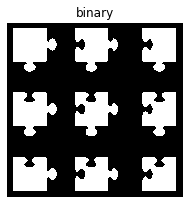

In [4]:
# Load the image with puzzle pieces
img = cv2.imread('puzzle.png')
# img = cv2.imread('pieces1.jpg')
# img = cv2.imread('online.png')

# Convert to gray scale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Binary threshold
_, img_binary = cv2.threshold(img_gray, 225, 255, cv2.THRESH_BINARY_INV)

# Show
show(img_binary, title='binary', cmap='gray')

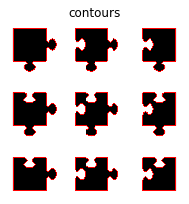

In [6]:
# Find the contours in the binary image
ci, contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (255, 0, 0), 1)

# Show
show(img_contours, title='contours')

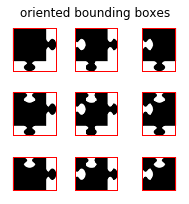

In [7]:
# Find oriented bounding rects from contours
oriented_bboxes = []
img_rect = img.copy()
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    # cv2.rectangle(img_rect, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # save
    oriented_bboxes.append(box)
    
    # draw a red 'nghien' rectangle
    cv2.drawContours(img_rect, [box], 0, (255, 0, 0), 1)

# Show
show(img_rect, title='oriented bounding boxes')

In [8]:
# extract and reorient all the pieces
pieces = []
for box in oriented_bboxes:
    # get rotated rect of contour and split into components
    center, size, angle = cv2.minAreaRect(box)
    if (size[0] == 0 or size[1] == 0):
        pieces.append(None)
        continue

    # not sure why this is needed, see 
    # http://felix.abecassis.me/2011/10/opencv-rotation-deskewing/
    if angle < -45.0:
            angle += 90.0
            width, height = size[0], size[1]
            size = (height, width)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # rotate the entire image around the center of the parking cell by the
    # angle of the rotated rect
    # codereview: not sure why it was necessary to swap width and height here,
    # probably related to the fact that we did angle += 90 earlier
    imgWidth, imgHeight = (img.shape[0], img.shape[1])
    rotated = cv2.warpAffine(img, M, (imgHeight, imgWidth), flags=cv2.INTER_CUBIC)

    # extract the rect after rotation has been done
    sizeInt = (np.int0(size[0]), np.int0(size[1]))
    uprightRect = cv2.getRectSubPix(rotated, sizeInt, center)
#     show(uprightRect)

    pieces.append(uprightRect)

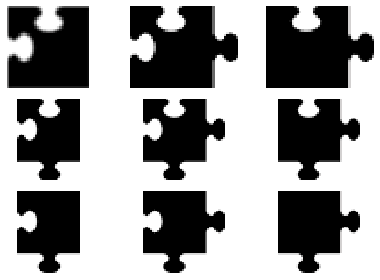

In [9]:
ncols = 3
nrows = math.ceil(len(pieces) / ncols)
# print(nrows)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, piece in zip(axs.flat, pieces):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    if piece is not None:
        ax.imshow(piece)
#     ax.set_title(str(interp_method))

plt.tight_layout()
plt.show()

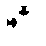

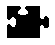

Not enough matches are found - 0/1


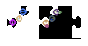

In [24]:
# Initiate SIFT detector
sift =  cv2.xfeatures2d.SIFT_create()

img1 = pieces[0].copy()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # queryImage
_, img1 = cv2.threshold(img1, 225, 255, cv2.THRESH_BINARY_INV)

img2 = pieces[1].copy()
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) # trainImage
_, img2 = cv2.threshold(img2, 225, 255, cv2.THRESH_BINARY_INV)
img2 = cv2.bitwise_not(img2)
show(img1, cmap="gray")
show(img2, cmap="gray")

# Binary threshold

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
#     good.append(m)
    if m.distance < 0.7*n.distance:
        good.append(m)
        
MIN_MATCH_COUNT = 1

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    d,h,w = img1.shape[::-1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    show(img2)
    
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
show(img3)